In [348]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

## Load data

In [277]:
df = pd.read_csv('data/anime_df_preprocessed.csv', index_col=0)
df.head()

,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Yaoi,Yuri,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,scaled_episodes,scaled_members
0,9.37,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0.000000,0.197867
1,9.26,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0.034673,0.782769
2,9.25,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.027518,0.112683
3,9.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.012658,0.664323
4,9.16,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.027518,0.149180


In [278]:
X = df.drop('rating', axis=1)
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [279]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8901, 51), (2968, 51), (8901,), (2968,))

In [280]:
regressionResult = {}

## Linear Regression

In [281]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
cv_scores = cross_val_score(linearRegression, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
y_pred = linearRegression.predict(X_test)

In [282]:
print(f"Cross-Validation MSE Scores: {cv_scores}")
print(f"Mean Cross-Validation MSE: {cv_scores.mean():.4f}")
print(f"Standard Deviation of Cross-Validation MSE: {cv_scores.std():.4f}")

Cross-Validation MSE Scores: [-0.67291176 -0.68970641 -0.66055822 -0.67640754 -0.66619616]
Mean Cross-Validation MSE: -0.6732
Standard Deviation of Cross-Validation MSE: 0.0099


In [283]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['LinearRegression'] = {"mse": mse, "r2": r2}
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.6495
Test Set R-squared: 0.3756


## Ridge Regression

In [284]:
ridgeRegression = RidgeCV()
ridgeRegression.fit(X_train, y_train)
y_pred = ridgeRegression.predict(X_test)

In [285]:
print(f"Best alpha: {ridgeRegression.alpha_}")

Best alpha: 1.0


In [286]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['RidgeCV'] = {"mse": mse, "r2": r2}
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.6490
Test Set R-squared: 0.3760


## GradientBoostingRegressor

In [287]:
gbRegressor = GradientBoostingRegressor()
gbRegressor.fit(X_train, y_train)
y_pred = gbRegressor.predict(X_test)

In [288]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")
gbRegressor.get_params()

Test Set Mean Squared Error: 0.4310
Test Set R-squared: 0.5856


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [305]:
gbRegressor2 = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [10, 20, 50, 100, 300, 500],
    'max_depth': [3, 5, 7, 9],
}
randomSearch = RandomizedSearchCV(estimator=gbRegressor2, param_distributions=param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [10, 20, 50, 100, 300,
                                                         500]},
                   scoring='neg_mean_squared_error')

In [306]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 300, 'max_depth': 3}


In [307]:
randomSearch.cv_results_

{'mean_fit_time': array([0.25698209, 0.55707321, 0.72004719, 0.18702111, 5.39969635,
        0.90665755, 1.88082466, 0.29061151, 1.4437191 , 4.41214437]),
 'std_fit_time': array([0.00989281, 0.01963046, 0.01531363, 0.01784418, 0.03224862,
        0.02175194, 0.020166  , 0.01976595, 0.02735333, 0.12742517]),
 'mean_score_time': array([0.00535893, 0.0027164 , 0.00379272, 0.00183921, 0.01482306,
        0.00845203, 0.00570016, 0.00379696, 0.00499353, 0.01110129]),
 'std_score_time': array([2.42043135e-03, 9.97970847e-05, 6.47129135e-04, 5.51248091e-05,
        1.08486940e-03, 8.13063136e-03, 1.11283427e-03, 2.13001512e-03,
        4.43790681e-05, 2.57787861e-04]),
 'param_n_estimators': masked_array(data=[20, 50, 50, 10, 300, 50, 300, 20, 100, 500],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 5, 7, 9, 9, 9, 3, 7, 7, 5],
          

In [308]:
best_gb = randomSearch.best_estimator_
y_pred = best_gb.predict(X_test)

In [309]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

regressionResult['GradientBoostingRegressor'] = {"mse": mse, "r2": r2}

# Print evaluation metrics
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.4128
Test Set R-squared: 0.6032


## RandomForestRegressor

In [310]:
rfRegressor = RandomForestRegressor()

param_grid= {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

randomSearch = RandomizedSearchCV(estimator=rfRegressor, param_distributions=param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
randomSearch.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'n_estimators': [100, 300, 500]},
                   scoring='neg_mean_squared_error')

In [311]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 300, 'max_depth': 10, 'bootstrap': True}


In [312]:
best_rf = randomSearch.best_estimator_
y_pred = best_rf.predict(X_test)

In [313]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

regressionResult['RandomForestRegressor'] = {"mse": mse, "r2": r2}

# Print evaluation metrics
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.4252
Test Set R-squared: 0.5912


## KNN

In [314]:
knn = KNeighborsRegressor()

param_grid= {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

randomSearch = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_mean_squared_error')

In [315]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'euclidean'}


In [316]:
best_knn = randomSearch.best_estimator_
y_pred = best_knn.predict(X_test)

In [317]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

regressionResult['KNeighborsRegressor'] = {"mse": mse, "r2": r2}

# Print evaluation metrics
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.5340
Test Set R-squared: 0.4866


## Results

In [318]:
pd.DataFrame(regressionResult).T

,mse,r2
LinearRegression,0.649508,0.375557
RidgeCV,0.649012,0.376034
GradientBoostingRegressor,0.412768,0.603161
RandomForestRegressor,0.425198,0.591211
KNeighborsRegressor,0.534032,0.486577


## Bin rating into low, mid, high

In [319]:
# Define bins and labels
bins = [0, 5, 8, 10]  # Define bin edges
labels = ['low', 'mid', 'high']  # Define bin labels

# Bin the data
df['binned_rating'] = pd.cut(df['rating'], bins=bins, labels=labels, include_lowest=True)

In [321]:
df.head()

,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Yuri,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,scaled_episodes,scaled_members,binned_rating
0,9.37,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0.000000,0.197867,high
1,9.26,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0.034673,0.782769,high
2,9.25,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0.027518,0.112683,high
3,9.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.012658,0.664323,high
4,9.16,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0.027518,0.149180,high


<Axes: >

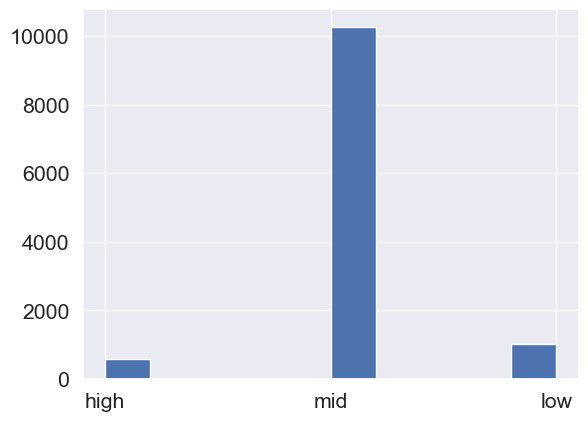

In [369]:
df['binned_rating'].hist()

### Under sampling

In [346]:
X = df.drop(columns=['rating','binned_rating'])
y = df['binned_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [351]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

<Axes: >

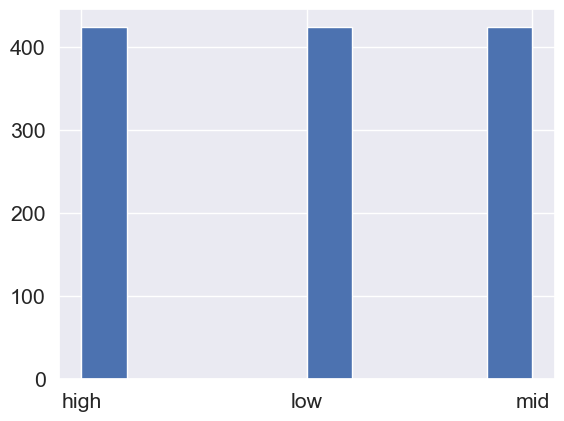

In [354]:
y_train_resampled.hist()

## GradientBoostingClassifier

In [356]:
gbClassifier = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 1.0],
    'max_depth': [3, 5, 7, 9],
}
randomSearch = RandomizedSearchCV(estimator=gbClassifier, param_distributions=param_grid, cv=5, n_jobs=-1)
randomSearch.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 1.0],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 300, 500]})

In [357]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}


In [358]:
best_gb = randomSearch.best_estimator_
y_pred = best_gb.predict(X_test)

In [359]:
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
cm = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

        high       0.23      0.83      0.36       153
         low       0.27      0.83      0.41       245
         mid       0.97      0.63      0.76      2570

    accuracy                           0.65      2968
   macro avg       0.49      0.76      0.51      2968
weighted avg       0.87      0.65      0.71      2968



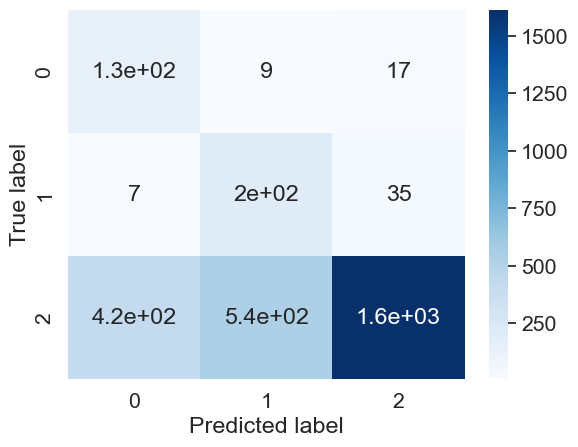

In [361]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## BalancedRandomForestClassifier

In [362]:
rfClassifier = RandomForestClassifier()

param_grid= {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

randomSearch = RandomizedSearchCV(estimator=rfClassifier, param_distributions=param_grid, cv=5, n_jobs=-1)
randomSearch.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'n_estimators': [100, 300, 500]})

In [363]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'bootstrap': False}


In [364]:
best_rf = randomSearch.best_estimator_
y_pred = best_rf.predict(X_test)

In [365]:
print(rfClassifier.class_weight)

None


In [366]:
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
cm = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

        high       0.24      0.87      0.37       153
         low       0.25      0.84      0.39       245
         mid       0.97      0.60      0.74      2570

    accuracy                           0.63      2968
   macro avg       0.49      0.77      0.50      2968
weighted avg       0.87      0.63      0.69      2968



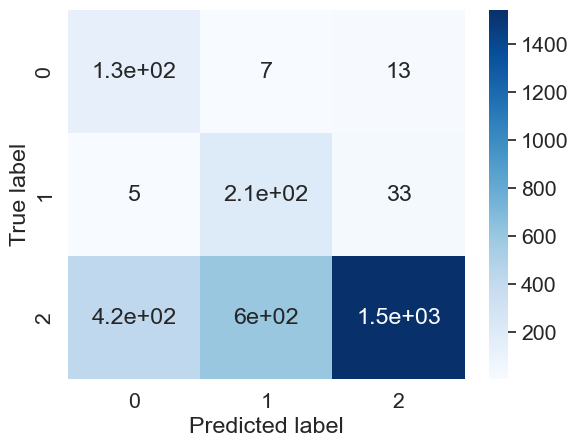

In [368]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()